# Metadata

Data from:
[Google Sheet](https://docs.google.com/spreadsheets/d/1Oh7zeWlQewzo9bDmnu5cenVM5a9zddVSlzS5OcUnhaE/edit?gid=801397250#gid=801397250)

Want to understand the samples:
- How many for each year
- Start and end dates
- Length of samples
- Repeats
- DNA yields

Could also look at contig stats files also in metadata


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse

Quite messy metadata so filling in some gaps for plotting 
- When there is no date I am going to use 15
- When there is no start_time I am going to use 10:00
- Adding a missing_date and missing_time col to keep track of this as well as leaving the original columns
- Have a BST_GMT column which I m going to use to adjust the start times before combining
- New DateTime_UTC is the one I should be using as 'start time'

Saving this output so i can use it in other analysis e.g. stacked bar chart in R


In [ ]:
import pandas as pd

def parse_metadata(df):

    # Fill missing dates with the 15th of the month - currently DD in the metadata
    df.loc[df['Date_Collected'].str.contains('DD', na=False), 'Date_Collected'] = df['Date_Collected'].str.replace('DD', '15')
  
    # Convert Date_Collected to datetime
    df['Date_Collected'] = pd.to_datetime(df['Date_Collected'], format='%d/%m/%y', errors='coerce')

    # Fill missing Start_Time with 10:00
    df['Start_Time'] = df['Start_Time'].fillna('10:00')

    # Convert Start_Time to timedelta for calculations
    df['Start_Time'] = pd.to_timedelta(df['Start_Time'] + ':00')  # Ensuring HH:MM:SS format

    # Combine Date and Time
    df['DateTime_UTC'] = df['Date_Collected'] + df['Start_Time']

    # Adjust for BST (convert BST times to UTC)
    df.loc[df['BST_GMT'] == 'BST', 'DateTime_UTC'] -= pd.Timedelta(hours=1)

    # Ensure final DateTime is in proper format
    df['DateTime_UTC'] = pd.to_datetime(df['DateTime_UTC'], errors='coerce')

    return df

def clean_sample_id(sample_id):
    if pd.isna(sample_id):
        return sample_id
    if ':' in sample_id:
        return sample_id.split(':')[1].strip()
    return sample_id.strip()

def transform_sample_id(sample_id):
    # Skip transformation if sample_id is NaN or empty
    if pd.isna(sample_id) or sample_id.strip() == '':
        return sample_id

    # Handle specific cases
    specific_cases = {
        'May_10_12_1': '14_05_24_(1)',
        'May_10_12_2': '14_05_24_(2)',
        'June_10_12_1': '18_06_24_(1)',
        'June_10_12_2': '18_06_24_(2)',
        'ChurchFarm1_Jul24': '25_07_24_(1)',
        'ChurchFarm2_Jul24': '25_07_24_(2)',
        'ChurchFarm1_Oct24': '17_10_24_(1)',
        'ChurchFarm2_Oct24': '17_10_24_(2)',
        'Reg_57_Pos' : 'Positive',
        'Reg_65_Neg' : 'Negative',
        # Add more specific cases here if needed
    }
    if sample_id in specific_cases:
        return specific_cases[sample_id]

    # General transformation for IDs like Reg_1_031022
    if sample_id.startswith('Reg_'):
        parts = sample_id.split('_')
        if len(parts) == 3:
            # Extract the date and reformat it
            date_part = parts[2]
            if len(date_part) == 6:  # Ensure the date part is in DDMMYY format
                day = date_part[:2]
                month = date_part[2:4]
                year = date_part[4:]
                repeat = metadata.loc[metadata['Sample_ID'] == sample_id, 'Repeat'].values[0]
                return f"{day}_{month}_{year}_({repeat})"
    return sample_id  # Return as-is if it doesn't match the expected format




# Read in data
metadata = pd.read_csv('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/All metadata - Regular CF collections (2023 & 2024).tsv', sep='\t')  

# Clean dates
metadata = parse_metadata(metadata)
# Clean the Sample_ID column
metadata['Sample_ID'] = metadata['Sample_ID'].apply(clean_sample_id)

#Order by date
metadata = metadata.sort_values(by='Date_Collected')
# Reset index after sorting
metadata.reset_index(drop=True, inplace=True)
# Add a repeat column to differentiate samples collected on the same date
metadata['Repeat'] = metadata.groupby('Date_Collected').cumcount() + 1
# Convert the Repeat column to integer, handling NaN values
metadata['Repeat'] = metadata['Repeat'].fillna(0).astype(int)

# Generate a new column Nice_ID based on transformed Sample_ID
metadata['Nice_ID'] = metadata['Sample_ID'].apply(transform_sample_id)

# Generate Sample column for grouping 
metadata['Sample'] = metadata['Nice_ID'].str.split('_').str[:3].str.join('_')

In [34]:
metadata['Sample_ID'].unique()

array(['Reg_1_031022', 'Reg_2_031022', 'Reg_3_011122', 'Reg_4_011122',
       'Reg_5_011222', 'Reg_6_011222', 'Reg_7_010123', 'Reg_8_010123',
       'Reg_9_010223', 'Reg_10_010223', 'Reg_11_010323', 'Reg_12_010323',
       'Reg_14_010423', 'Reg_13_010423', 'Reg_15_250523', 'Reg_16_250523',
       'Reg_17_020623', 'Reg_18_020623', 'Reg_19_060623', 'Reg_20_140623',
       'Reg_21_140623', 'Reg_22_210623', 'Reg_23_210623', 'Reg_24_300623',
       'Reg_25_300623', 'Reg_27_070723', 'Reg_26_070723', 'Reg_28_120723',
       'Reg_29_120723', 'Reg_30_200723', 'Reg_31_200723', 'Reg_32_270723',
       'Reg_33_270723', 'Reg_34_030823', 'Reg_35_030823', 'Reg_36_090823',
       'Reg_37_090823', 'Reg_38_170823', 'Reg_39_170823', 'Reg_2_070224',
       'Reg_1_070224', 'Reg_3_120224', 'Reg_4_120224', 'Reg_5_210224',
       'Reg_6_210224', 'Reg_7_270224', 'Reg_8_270224', 'Reg_9_060324',
       'Reg_10_060324', 'Reg_11_110324', 'Reg_12_110324', 'Reg_14_190324',
       'Reg_13_190324', 'Reg_15_270324', 'R

In [ ]:
# metadata.to_csv('../metadata/metadata_cleaned.tsv', sep='\t', index=False)


## Calculate some stats from the metadata

- How many samples per year (and month)
- Earliest and latest sample from each year
- Plot of DNA yield (maybe hue by Collection_Length_Min)

In [124]:
# How many samples are there?
print(f'There are {metadata.shape[0]} samples in the dataset')

# How many unique Sample_IDs are there? (2xNaNs)
print(f'There are {metadata["Sample_ID"].nunique()} unique Sample_IDs in the dataset')

#How many samples are there for each year
metadata['Year'] = metadata['DateTime_UTC'].dt.year
print(metadata['Year'].value_counts())

# How many samples are there for each month
metadata['Month'] = metadata['DateTime_UTC'].dt.strftime('%b')
# How many samples are there for each month by year
print(metadata.groupby(['Year', 'Month']).size().unstack(fill_value=0))

There are 107 samples in the dataset
There are 105 unique Sample_IDs in the dataset
Year
2024.0    64
2023.0    33
2022.0     6
Name: count, dtype: int64
Month   Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep
Year                                                              
2022.0    0    0    2    0    0    0    0    0    0    2    2    0
2023.0    2    6    0    2    2    8    9    2    2    0    0    0
2024.0    8    8    0    8    0   10    6    8    6    0    2    8


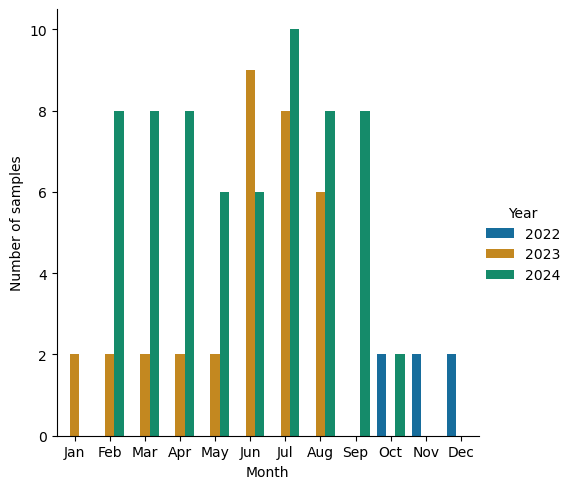

In [125]:
metadata['Year'] = metadata['Year'].astype(str).str.split('.').str[0]  # Clean 'Year'
fil_metadata = metadata[(metadata['Year'] != 'nan')]


# Plot the number of samples by month
sns.catplot(data=fil_metadata,
            x='Month',
            kind='count',
            order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            hue='Year',
            palette='colorblind')

ylabel = plt.ylabel('Number of samples')
# plt.savefig('../Graphs/Number_of_samples_by_month.svg')

## DNA yield

- consider pre and post WGA
- 2023 - WGA
- 2024 no WGA just initial DNA conc

In [129]:
columns_to_convert = ['DNA_Concentration_(ng/ul)', 'DNA_Concentration_WGA_(ng/ul)']

for column in columns_to_convert:
    fil_metadata[column] = pd.to_numeric(fil_metadata[column], errors='coerce')

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_7186/3576719391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_metadata[column] = pd.to_numeric(fil_metadata[column], errors='coerce')


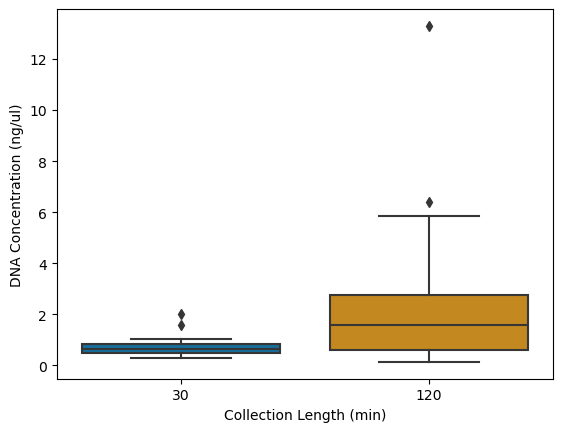

In [136]:
fil_metadata['Collection_Length_Min'] = fil_metadata['Collection_Length_Min'].astype(str).str.split('.').str[0]  # Clean 'Year'

# Filter out samples with Collection_Length_Min equal to 60
fil_metadata = fil_metadata[fil_metadata['Collection_Length_Min'] != '60']

sns.boxplot(
    data=fil_metadata,
    x='Collection_Length_Min',
    y='DNA_Concentration_(ng/ul)',
    palette='colorblind'
)

ylabel = plt.ylabel('DNA Concentration (ng/ul)')
xlabel = plt.xlabel('Collection Length (min)')
plt.savefig('../Graphs/DNA_concentration_vs_collection_length.svg')